<a href="https://colab.research.google.com/github/fmathews11/College_Basketball_Functions/blob/main/Pulling_Gameplan_From_Kenpom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
!pip install kenpompy
!pip install mechanicalsoup
import mechanicalsoup,pandas as pd,numpy as np
from bs4 import BeautifulSoup
from kenpompy.utils import login
import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
browser = login()
def get_team_gameplan(browser,team):

  #Pull in HTML
  url = 'https://kenpom.com/gameplan.php?team='+str(team)
  browser.open(url)
  raw_source = browser.get_current_page()
  table = raw_source.find_all('table')
  df = pd.read_html(str(table[0]))[0]

  #Let's Clean it up
  df.columns = [i[0] +  "_" +i[1] for i in df.columns.tolist()]
  df = df.drop([df.columns[i] for i in [1,7,12,14,18]],axis = 1)

  #Column name cleaning
  for i in df.columns:
    if "." in i:
      df = df.rename(columns = {i:i[:-2]})
  for i in df.columns:
    if "Unnamed" in i:
      df = df.rename(columns = {i:i.split()[-1]})
  for i in df.columns:
    if "level" in i:
      df = df.rename(columns = {i:i.split("_")[-1]})


  #Remove Extra Junk From the end
  cutoff_value = np.where(df.Date == "Correlations (R x 100)")[0][0]
  df = df.iloc[:cutoff_value,:]

  #Splitting the results column
  result_vals = [i for i in df.Result.tolist()]
  df.Result = [str(i[0]) for i in result_vals]
  df['Score'] = [str(i.split(',')[-1]) for i in result_vals]

  col_names = ['Date',
              'Opponent',
              'Result',
              'Location',
              'Pace',
              'Offense_Eff',
              'Offense_eFG%',
              'Offense_TO%',
              'Offense_OR%',
              'Offense_FTR',
              'Offense_2P%',
              'Offense_3P%',
              'Offense_3PA%',
              'Defense_Eff',
              'Defense_eFG%',
              'Defense_TO%',
              'Defense_OR%',
              'Defense_FTR',
              'Defense_2P%',
              'Defense_2P%',
              'Defense_3P%',
              'Defense_3P%',
              'Defense_3PA%',
              'Score']
  df.columns = col_names
  df.Result = df.Result.map({"W":1,"L":0})

  #Coerce all strings to numeric type for computation
  for i in df.columns:
   try:
     df[i] = pd.to_numeric(df[i])
   except:
     pass

  return df


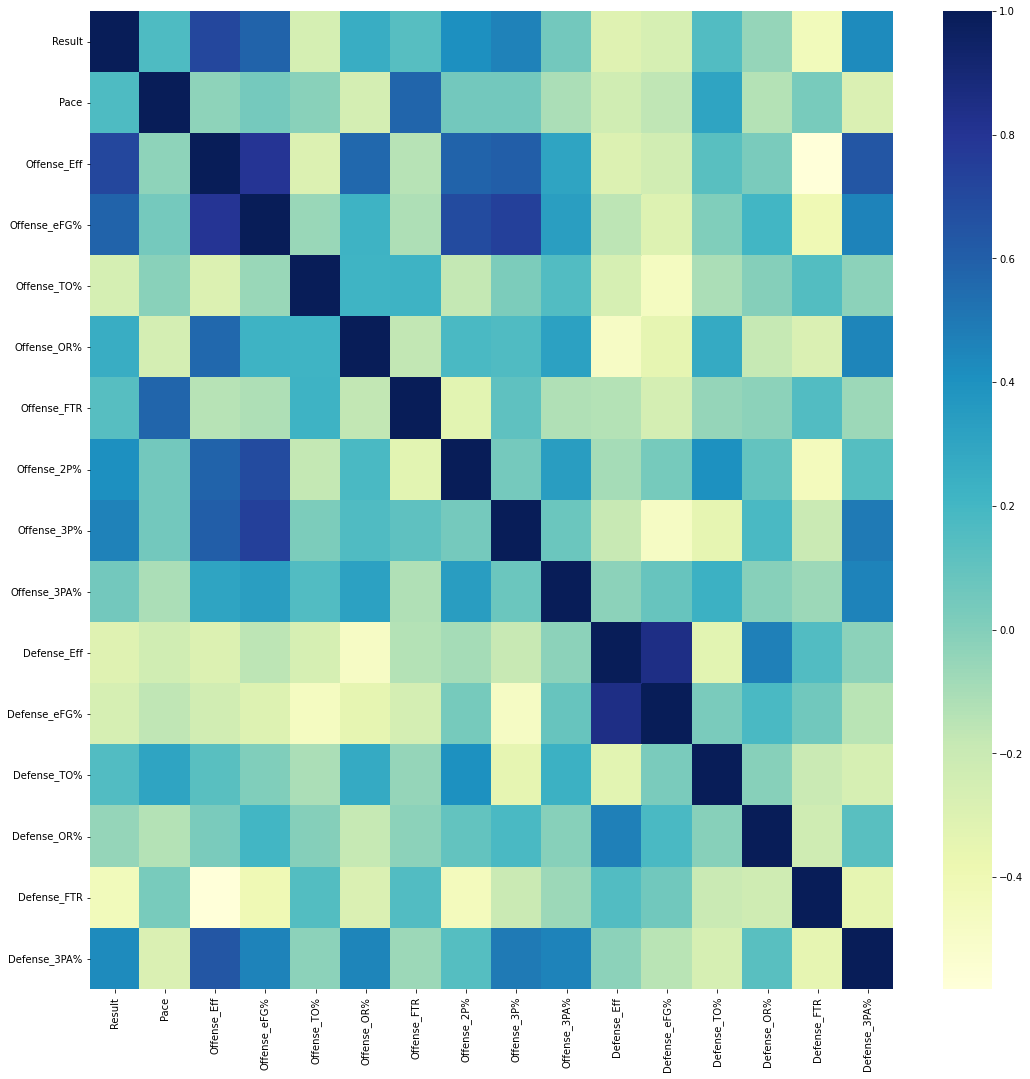

In [78]:
df = get_team_gameplan(browser,'Purdue')
plt.figure(figsize = (18,18))
sns.heatmap(df.corr(),cmap="YlGnBu")
plt.show();

In [76]:
corr = df.corr()
high_corr = np.where(corr >= 0.6)
[(corr.columns[x],corr.columns[y],round(corr.iloc[x,y],2)) for x,y in zip(*high_corr) if x!=y and x<y]

[('Result', 'Offense_Eff', 0.71),
 ('Offense_Eff', 'Offense_eFG%', 0.8),
 ('Offense_Eff', 'Offense_3P%', 0.6),
 ('Offense_Eff', 'Defense_3PA%', 0.64),
 ('Offense_eFG%', 'Offense_2P%', 0.69),
 ('Offense_eFG%', 'Offense_3P%', 0.74),
 ('Defense_Eff', 'Defense_eFG%', 0.85)]

In [79]:
df

,Date,Opponent,Result,Location,Pace,Offense_Eff,Offense_eFG%,Offense_TO%,Offense_OR%,Offense_FTR,Offense_2P%,Offense_3P%,Offense_3PA%,Defense_Eff,Defense_eFG%,Defense_TO%,Defense_OR%,Defense_FTR,Defense_2P%,Defense_2P%,Defense_3P%,Defense_3P%,Defense_3PA%,Score
0,Tue Nov 9,Bellarmine,1,H,67,143.7,64.3,19.5,50.0,51.8,60.0,44.4,64.3,100.3,50.9,15.0,20.6,13.6,12-24,50.0,12-35,34.3,59.3,96-67
1,Fri Nov 12,Indiana St.,1,H,73,126.2,60.3,16.5,36.4,55.2,60.5,40.0,34.5,91.9,43.8,16.5,25.0,21.9,19-38,50.0,6-26,23.1,40.6,92-67
2,Tue Nov 16,Wright St.,1,H,75,128.3,60.5,22.7,52.8,31.3,61.5,39.3,41.8,69.5,34.8,20.1,13.9,23.7,13-33,39.4,5-26,19.2,44.1,96-52
3,Sat Nov 20,North Carolina,1,N,77,121.5,63.9,11.8,13.8,36.1,63.2,43.5,37.7,109.7,53.6,18.3,30.8,17.4,19-40,47.5,12-29,41.4,42.0,93-84
4,Sun Nov 21,Villanova,1,N,60,132.5,61.8,18.2,42.9,25.4,59.4,43.5,41.8,122.6,56.0,6.6,27.8,29.3,13-24,54.2,13-34,38.2,58.6,80-74
5,Fri Nov 26,Nebraska Omaha,1,H,67,145.5,65.2,18.0,50.0,40.7,59.5,52.9,28.8,60.0,30.9,13.5,17.0,3.2,12-35,34.3,5-28,17.9,44.4,97-40
6,Tue Nov 30,Florida St.,1,H,68,136.3,69.5,19.1,41.7,23.7,67.6,48.0,42.4,95.2,47.6,19.1,29.7,9.5,18-39,46.2,8-24,33.3,38.1,93-65
7,Fri Dec 3,Iowa,1,H,76,101.3,50.0,22.4,25.0,74.0,41.9,42.1,38.0,92.1,44.4,11.8,15.0,35.5,20-41,48.8,5-21,23.8,33.9,77-70
8,Thu Dec 9,Rutgers,0,A,66,103.7,46.7,16.8,42.1,26.2,51.4,26.9,42.6,106.8,59.4,24.4,20.8,37.5,18-34,52.9,7-14,50.0,29.2,70-68
9,Sun Dec 12,N.C. State,1,N,67,109.3,54.2,18.7,32.4,41.7,64.1,23.8,35.0,96.0,48.4,17.3,17.9,24.2,18-41,43.9,8-21,38.1,33.9,82-72


In [ ]:
target_df = df[['Opponent','Defense_Eff']]
target_df.rename(columns = {'Defense_Eff':"Raw_Offensive_Efficiency_Against_Purdue"},inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [12]:
import kenpompy.summary as kp
sum_df = kp.get_efficiency(browser,2021)
sum_df_ = sum_df.copy()
sum_df

IndexError: ignored

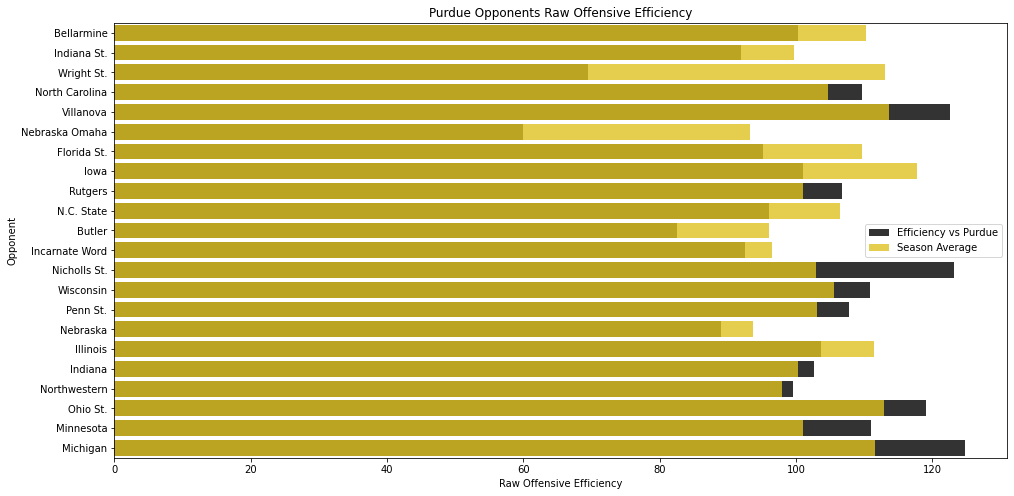

In [ ]:
import matplotlib.pyplot as plt
off_dict = dict(zip(sum_df.Team,sum_df['Off. Efficiency-Raw']))
melted = pd.melt(target_df,id_vars = ['Opponent'])
melted.value = melted.value.astype(float)
plt.figure(figsize = (16,8))
g = sns.barplot(data = melted,
            x = "value",
            y = 'Opponent',
            hue = 'variable',
            orient = "h",
            dodge = False,
            palette = ['black','gold'],
            ci = None,
            alpha = 0.8)
plt.legend(labels = ['Efficiency vs Purdue','Season Average'])
plt.title("Purdue Opponents Raw Offensive Efficiency")
plt.xlabel("Raw Offensive Efficiency")
plt.show();

In [ ]:
target_df

,Opponent,Raw_Offensive_Efficiency_Against_Purdue,Season_Average_Offensive_Efficiency
0,Bellarmine,100.3,110.3
1,Indiana St.,91.9,99.7
2,Wright St.,69.5,113.0
3,North Carolina,109.7,104.7
4,Villanova,122.6,113.7
5,Nebraska Omaha,60.0,93.2
6,Florida St.,95.2,109.7
7,Iowa,92.1,117.7
8,Rutgers,106.8,101.0
9,N.C. State,96.0,106.5
